# Demographic Impact on Mental Health Responses 

## INTRODUCTION

Goal: Understand how age, gender, or location influence survey responses.

Are certain age groups more likely to report anxiety or depression?
Do responses differ significantly between men and women?
Is there a regional or national variation in responses?

Why?
This can provide insights into which groups might need targeted mental health interventions.

Importing libraries :

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from MentalHealthCustomFunctionsDictionaries import detect_outliers, question_mapping

Defining the database :

In [2]:
db_path = "mental_health.sqlite"

Connecting the SQLite database :

In [3]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection :

In [4]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

## DATA CLEANING

Fetching all table names :

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Previewing each table's schema :

In [6]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Defining tables :

In [7]:
answer_df = pd.read_sql("SELECT * FROM Answer", conn)
question_df = pd.read_sql("SELECT * FROM Question", conn)
survey_df = pd.read_sql("SELECT * FROM Survey", conn)

Merging tables to create a full dataset :

In [8]:
merged_df = answer_df.merge(
    question_df, left_on="QuestionID", right_on="questionid", how="left"
).merge(survey_df, on="SurveyID", how="left")

Standardizing and grouping similar questions across survey years :

In [9]:
merged_df["questiontext"] = merged_df["questiontext"].replace(question_mapping)

Handling missing values :

In [10]:
merged_df["AnswerText"] = merged_df["AnswerText"].fillna("Not Provided")

Standardizing gender responses :

In [11]:
gender_map = {
    "M": "Male",
    "F": "Female",
    "Male": "Male",
    "Female": "Female",
    "Other": "Other",
}
merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"]
    .str.strip()
    .str.title()
)
merged_df.loc[merged_df["questiontext"] == "Gender", "AnswerText"] = merged_df.loc[
    merged_df["questiontext"] == "Gender", "AnswerText"
].replace(gender_map)

Converting age to numeric :

In [12]:
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Removing outliers in Age column using detect_outliers from MentalHealthCustomFunctions, converting 'AnswerText' to numeric :

In [13]:
temp_age_numeric = pd.to_numeric(
    merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"], errors="coerce"
)

Detecting and replacing outliers, ensuring negative ages and unrealistically old ages are handled :

In [14]:
temp_age_numeric_cleaned = detect_outliers(
    temp_age_numeric, min_valid_age=0, max_valid_age=100
)
merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"] = (
    temp_age_numeric_cleaned.fillna("Not Provided")
)

Standardizing country names :


In [15]:
merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"] = (
    merged_df.loc[merged_df["questiontext"] == "Country", "AnswerText"]
    .str.strip()
    .str.title()
)

In [16]:
# Highlighted Changes:
age_series = merged_df.loc[merged_df["questiontext"] == "Age", "AnswerText"].dropna()

# Force conversion to numeric again, and filter out non numeric values.
age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=[0, 19, 29, 39, 49, 59, 100],
        labels=["<20", "20-29", "30-39", "40-49", "50-59", "60+"],
        right=False,
    )
else:
    merged_df.loc[merged_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

Aggregating responses to remove duplicates within the same survey and question :

In [17]:
# Add this before the group by.
print(f"merged_df shape before group by: {merged_df.shape}")

merged_df = (
    merged_df.groupby(["SurveyID", "questiontext"])
    .agg(
        {"AnswerText": lambda x: x.mode()[0] if not x.mode().empty else "Not Provided"}
    )
    .reset_index()
)

merged_df shape before group by: (236898, 8)


In [18]:
# Add this after the group by.
print(f"merged_df shape after group by: {merged_df.shape}")

merged_df shape after group by: (314, 3)


Ensuring all questions appear in all survey years :

In [19]:
full_survey_list = merged_df["SurveyID"].unique()
full_question_list = merged_df["questiontext"].unique()
full_index = pd.MultiIndex.from_product(
    [full_survey_list, full_question_list], names=["SurveyID", "questiontext"]
)
expanded_df = (
    merged_df.set_index(["SurveyID", "questiontext"]).reindex(full_index).reset_index()
)

Filling missing answers with "Not Asked" for surveys where the question was absent :

In [20]:
expanded_df["AnswerText"] = expanded_df["AnswerText"].fillna("Not Asked")

 Printing cleaned dataset :

In [21]:
print(expanded_df.head())

   SurveyID                                      questiontext  AnswerText
0      2014                                               Age        29.0
1      2014  Anonymity Protection for Mental Health Treatment  Don't know
2      2014                  Any additional notes or comments          -1
3      2014           Awareness of Mental Health Care Options          No
4      2014                                      Company Size        6-25


##  Demographic Distribution

In [22]:
# Print column names to check if "Age" exists
print(merged_df.columns)

Index(['SurveyID', 'questiontext', 'AnswerText'], dtype='object')


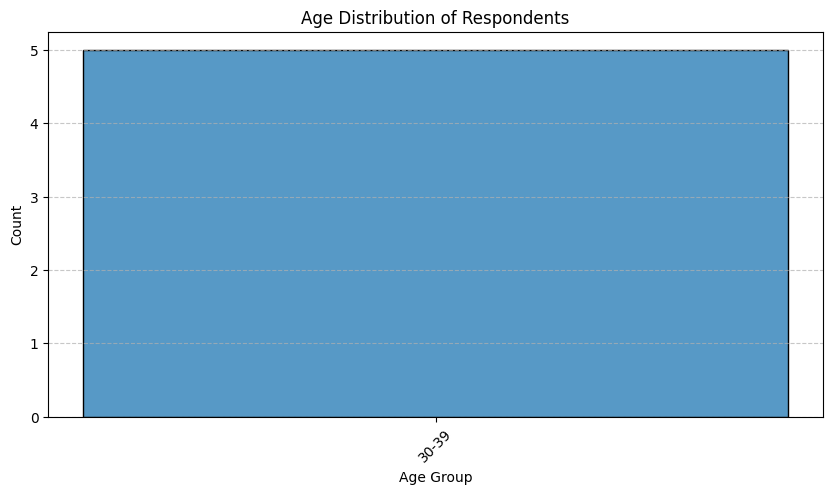

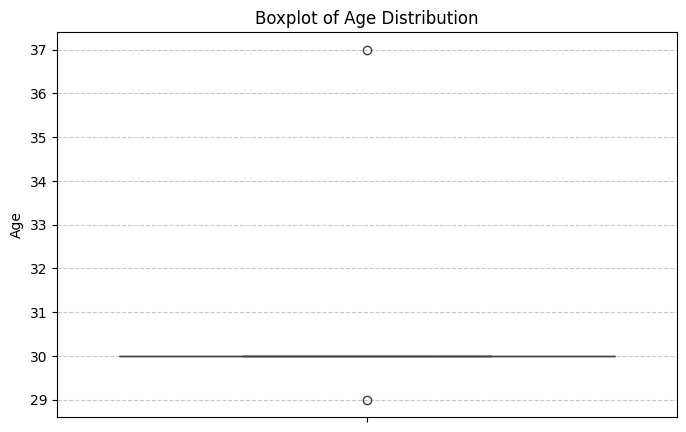

In [23]:
# Define age bins and labels
bins = [0, 19, 29, 39, 49, 59, 100]
labels = ["<20", "20-29", "30-39", "40-49", "50-59", "60+"]

# Create "Age Group" column on the expanded_df
age_series = expanded_df.loc[
    expanded_df["questiontext"] == "Age", "AnswerText"
].dropna()

age_series = pd.to_numeric(age_series, errors="coerce").dropna()

if not age_series.empty:
    expanded_df.loc[expanded_df["questiontext"] == "Age", "Age Group"] = pd.cut(
        age_series,
        bins=bins,
        labels=labels,
        right=False,
    )
else:
    expanded_df.loc[expanded_df["questiontext"] == "Age", "Age Group"] = "Not Provided"

# Plot histogram for age groups
plt.figure(figsize=(10, 5))
sns.histplot(
    expanded_df["Age Group"].dropna(), bins=len(labels), kde=False, discrete=True
)
plt.title("Age Distribution of Respondents")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot boxplot to confirm outlier handling
plt.figure(figsize=(8, 5))
sns.boxplot(
    y=expanded_df.loc[expanded_df["questiontext"] == "Age", "AnswerText"]
    .dropna()
    .astype(float)
)
plt.title("Boxplot of Age Distribution")
plt.ylabel("Age")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [24]:
print(age_series.unique())  # Add this line

[29. 30. 37.]
